In [349]:
import pandas as pd
import os
from pathlib import Path
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split, KFold
from PIL import Image

In [309]:
mpl.rcParams['figure.dpi']= 200
plt.rcParams['figure.figsize'] = [5,4]

In [72]:
data_folder = "../data/original/"
annotated_folder = "../data/training_data/"
testdata_folder = "../data/testdata_dont_touch/"

In [22]:
def read_samples(folder):
    samples = []
    for file in os.listdir(data_folder):
         filename = os.fsdecode(file)
         if filename.endswith(".jpg"):
            fullname = data_folder + file
            fullname_no_extension = data_folder + Path(fullname).stem
            outcome = pd.read_json(fullname_no_extension + ".json")
            samples.append((filename, outcome))
    return samples

In [23]:
samples = read_samples(data_folder)

In [24]:
def eval(samples):
    success = [x for x in samples if len(x[1]["solution"]) > 0]
    print(len(success))
    print(len(samples))
    return len(success) / len(samples)

In [25]:
eval(samples)

63
217


0.2903225806451613

In [26]:
X_train, X_test, y_train, y_test = train_test_split(samples, samples, test_size=0.20, random_state=42)
print(len(X_train))
print(len(X_test))

173
44


In [41]:
def move_annotated_files(samples, source_folder, destination_folder):
    for test_sample in X_test:
        image_filepath = test_sample[0]
        image_fullpath = source_folder + image_filepath
        image_target = destination_folder + image_filepath
        name_no_ext = Path(image_filepath).stem
        annotation_filepath = name_no_ext + ".xml"
        annotation_fullpath = source_folder + annotation_filepath
        annotation_target = destination_folder + annotation_filepath
        filename = os.fsdecode(image_filepath)
        os.rename(image_fullpath, image_target)
        os.rename(annotation_fullpath, annotation_target)

In [43]:
class SudolverModel():
    def fit(image_filenames):
        pass
    
    def predict(image_filename):
        pass
    
    def get_params():
        pass

In [63]:
def apply_cv(samples, num_splits):
    kf = KFold(n_splits=num_splits, random_state=42, shuffle=True)
    for train_index, val_index in kf.split(samples):
        X_train_cv = samples[train_index]
        X_val_cv = samples[val_index]

In [64]:
apply_cv(np.array(X_train), 10)

In [80]:
def read_image(filepath):
    return cv2.imread(filepath)

In [81]:
def to_rgb_from_bgr(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [82]:
def to_grayscale_from_bgr(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [119]:
def eq_hist_from_bgr(image):
    return cv2.equalizeHist(to_grayscale_from_bgr(image))

In [298]:
def unsharp_masking(image, k=10):
    normalized = image / 255.0
    blurred = cv2.GaussianBlur(normalized, [5, 5], 3, 3)
    mask = normalized - blurred
    sharp = normalized + k*mask
    sharp[sharp > 1] = 1
    sharp[sharp < 0] = 0
    return sharp

In [299]:
def laplacian(image, alpha=10):
    normalized = image / 255.0
    laplacian = cv2.Laplacian(normalized, cv2.CV_64F)
    sharp = normalized - alpha * laplacian
    sharp[sharp > 1] = 1
    sharp[sharp < 0] = 0
    return sharp

In [350]:
def save_higher_dpi(source_filepath, target_filepath, new_dpi=150):
    im = Image.open(source_filepath)
    im.save(target_filepath, dpi=(new_dpi,new_dpi))

In [354]:
def perspective_transform(image, conjugates, output_size=512):
    output = np.float32([[0, 0], [output_size - 1, 0], [output_size - 1, output_size - 1], [0, output_size - 1]])
    matrix = cv2.getPerspectiveTransform(conjugates, output)
    return cv2.warpPerspective(image, matrix, (output_size, output_size), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

In [310]:
filepath = annotated_folder + X_train[15][0]

In [ ]:
image = read_image(filepath)
plt.imshow(to_rgb_from_bgr(image))

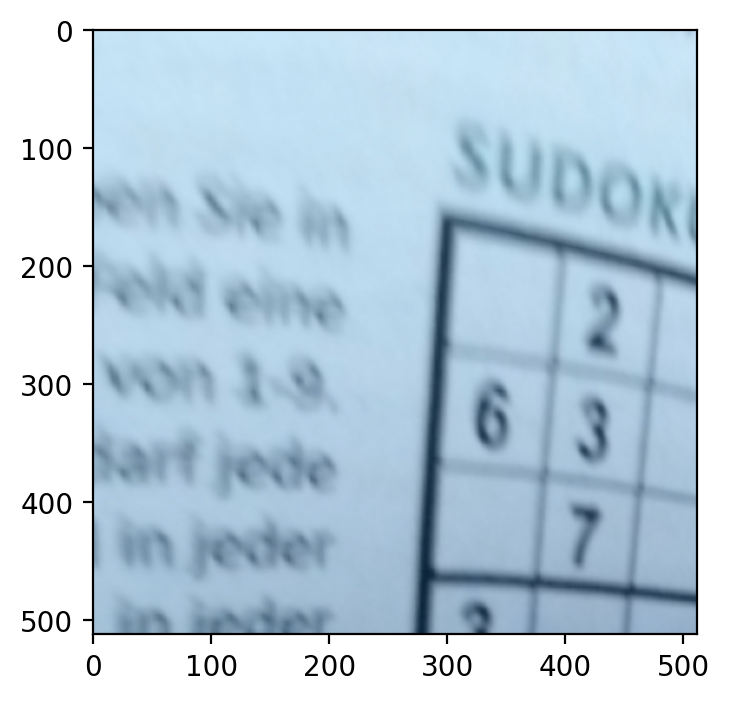

In [362]:
plt.imshow(perspective_transform(image, np.float32([[75,150], [418,59], [442,443], [29,438]])))

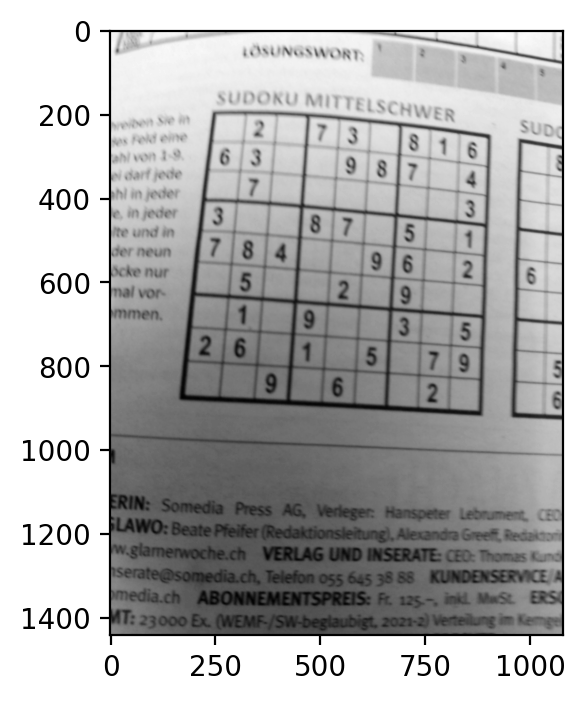

In [312]:
plt.imshow(to_grayscale_from_bgr(image), cmap='gray')

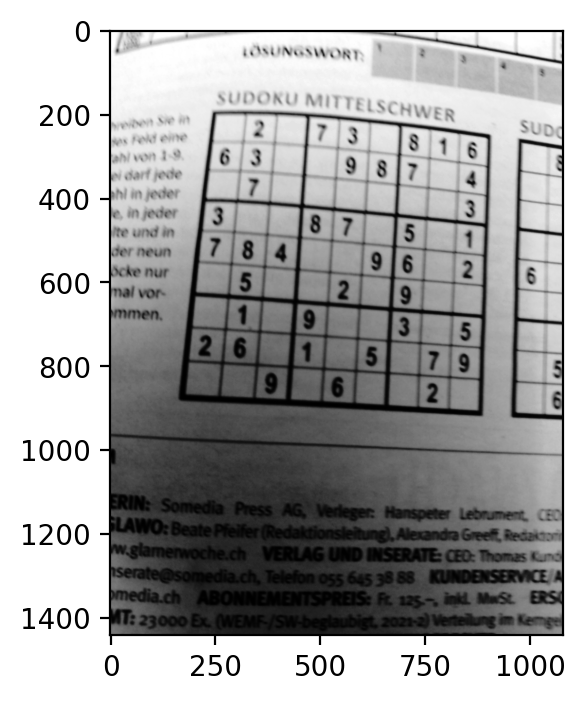

In [321]:
plt.imshow(eq_hist_from_bgr(image), cmap='gray')

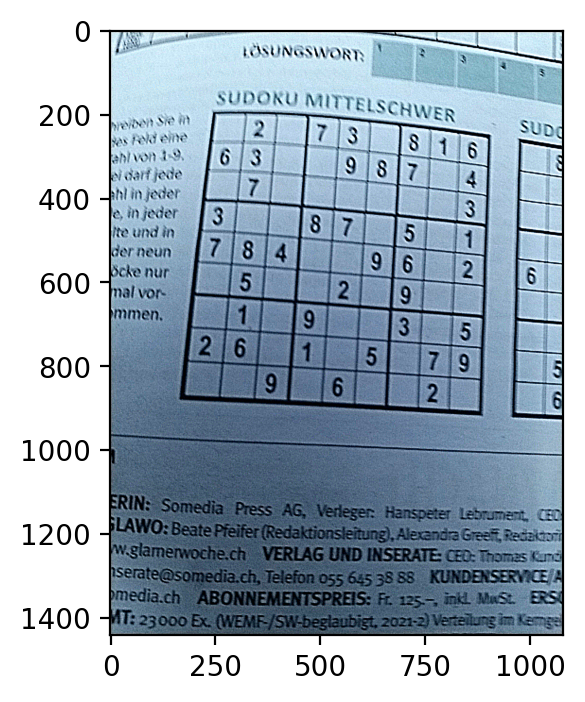

In [346]:
sharp = unsharp_masking(image, k=15)
plt.imshow(sharp)

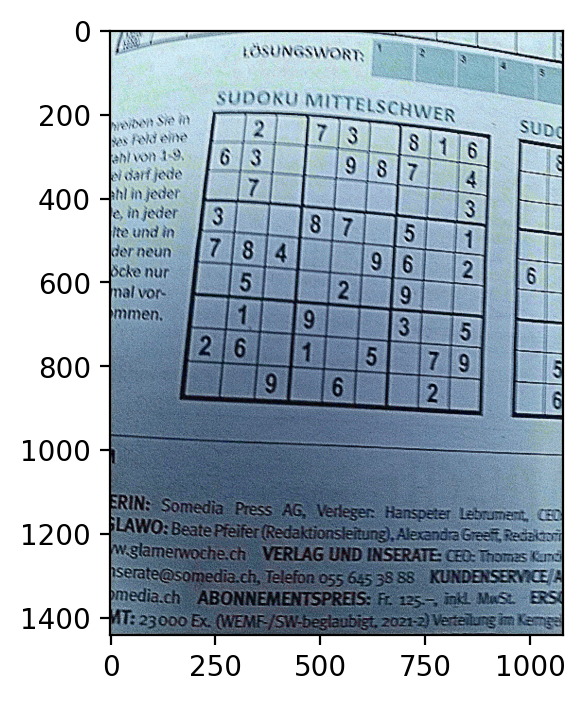

In [347]:
sharp = laplacian(image, alpha=15)
plt.imshow(sharp)